# Configuration
____________________

In [ ]:
# set main directories
BASE_DIR = '/content/gdrive/MyDrive/AML_project/project/'
UTILS_DIR = BASE_DIR + 'utils'
DATA_DIR = BASE_DIR + 'data/'
TOKENIZER_DIR = BASE_DIR + 'tokenizers/'
MODEL_DIR = BASE_DIR + 'models/'
PRED_DIR = BASE_DIR + 'predictions/'
# mount drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
# set utils directory
import sys
sys.path.append(UTILS_DIR)


Mounted at /content/gdrive


# Imports
____________________

In [ ]:
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import nltk
import string
import re
import io
from tensorflow import keras, random
from tensorflow.keras import layers, regularizers, callbacks, metrics, initializers
from keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D, Input, Concatenate, Flatten, Dropout, SpatialDropout1D, LSTM, GRU, Bidirectional, GlobalAvgPool1D, GlobalMaxPool1D
from keras.models import Model, load_model, save_model
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc, f1_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix
# custom imports
from utils import getComments, train_val_split
from preprocessing import Preprocessor
from embeddings import load_glove_vectors, load_fasttext_vectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Setup

In [ ]:
### SETTINGS ###
settings = {
      'RANDOM_STATE': 42,
      'EMBEDDING_CHOICE': 'fasttext', # 'fasttext', 'glove'
      'SOURCES': ['de', 'fr', 'es'], # ['de', 'fr', 'es', 'syn_0', 'syn_1', 'syn_2'], use [] to keep only original data 
      'TEST_SIZE': 0.2,
      'UNDERSAMPLE': False
}
# set seeds
seed(settings['RANDOM_STATE'])
random.set_seed(settings['RANDOM_STATE'])
# shortcut
labels = ['toxic', 'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']
targets = ['toxic', 'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate', 'is_toxic']

# Load data
____________________

In [ ]:
# load train
if settings['UNDERSAMPLE']:
  train = pd.read_csv(DATA_DIR + 'train_aug_und_cleaned.csv', sep='\t')
else:
  train = pd.read_csv(DATA_DIR + 'train_aug_cleaned.csv', sep='\t')

# load test
test = pd.read_csv(DATA_DIR + 'test_cleaned.csv', sep='\t')

# load test labels
test_labels = pd.read_csv(DATA_DIR + 'test_labels_cleaned.csv', sep='\t')

# Prepare data for model inputs
____________________

To perform the two steps of the classification, it's necessary to prepare two distinct training set with their own specific vocabulary and embeddings.

## Binary model

In [ ]:
# instantiate Preprocessor object
p_1 = Preprocessor(path_to_tokenizer=TOKENIZER_DIR + 'base_tokenizer.pickle')

It is necessary that during the split between training set and validation set, the augmented data will be added to the same set of their original values to avoid overfitting.

In [ ]:
# split in train and validation
X_train_1, X_val_1, y_train_1, y_val_1 = train_val_split(X = train,
                                                          targets=targets,
                                                          val_size=settings['TEST_SIZE'],
                                                          random_state=settings['RANDOM_STATE'], 
                                                          sources=settings['SOURCES'])

y_train_1 = y_train_1['is_toxic']
y_val_1 = y_val_1['is_toxic']
X_test_1 = test['comment_text'] 
y_test_1 = test_labels['is_toxic']


Augmenting with de ...
Augmenting with fr ...
Augmenting with es ...


In [ ]:
print('Training size:', len(X_train_1))
print('Validation size:', len(X_val_1))
print('Test size:', len(X_test_1))
print('Split ratio:', round(len(X_val_1)/len(X_train_1), 2))

Training size: 166332
Validation size: 41777
Test size: 63517
Split ratio: 0.25


In [ ]:
# fit tokenizer
p_1.fitTokenizer(X_train_1)
print('Vocabulary 1 size: ',p_1.getVocabularySize())

Vocabulary 1 size:  146904


In [ ]:
# save fitted binary tokenizer
p_1.saveTokenizer(TOKENIZER_DIR + 'fitted_binary_tokenizer_gru')

In [ ]:
# transform train, val and test comments to sequences
X_train_1 = p_1.toSequences(X_train_1)
X_val_1 = p_1.toSequences(X_val_1)
X_test_1 = p_1.toSequences(X_test_1)

In [ ]:
# load embedding
if settings['EMBEDDING_CHOICE'] == 'glove':
  embeddings_1 = load_glove_vectors(DATA_DIR + 'glove/glove.twitter.27B.200d.txt', p_1.getTokenizer())
if settings['EMBEDDING_CHOICE'] == 'fasttext':
  embeddings_1 = load_fasttext_vectors(DATA_DIR + 'fasttext/crawl-300d-2M.vec', p_1.getTokenizer())

print('Embeddings 1 shape: ', embeddings_1.shape)

Loading FastText Model and building embedding matrix with vocabulary...
DONE
Embeddings 1 shape:  (146904, 300)


# utils

In [ ]:
def saveWordIndexes(tokenizer):
  with open(base_dir + 'saved_model/word_index.json', 'w') as fp:
    json.dump(tokenizer.word_index, fp)

def plotHistory(history, metrics, title):
  plt.title(title)
  plt.plot(history.history[metrics[0]])
  plt.plot(history.history[metrics[1]])
  plt.ylabel(metrics[0])
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

def plot_roc(y_test, y_score):
  # plot settings
  lw = 2
  figure(figsize=(10,8))
  num_classes = 6
  y_test = np.array(y_test)
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(num_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(num_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= num_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


  # Plot all ROC curves
  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(num_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(labels[i], roc_auc[i]))
  
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multilabel ROC CURVE')
  plt.legend(loc="lower right")
  plt.show()

def print_confusion_matrix(y_true, y_pred):
  i = 0
  for cm in multilabel_confusion_matrix(y_true, y_pred, samplewise=False):
    print('###################')
    print(labels[i])
    print(cm)
    i = i+1

# Build model - Bidirectional GRU
____________________

In [ ]:
def BiGRU(vocab_size, max_len, embedding, output_size):
  #### INITIALIZER
  initializer = initializers.GlorotUniform(seed=settings['RANDOM_STATE'])

  #### INPUT
  inputs = Input(shape=(max_len,))

  #### EMBEDDING LAYER
  embedding = Embedding(input_dim=vocab_size, output_dim=embedding.shape[1], weights=[embedding], input_length=max_len, trainable=False)(inputs)

  #### GRU LAYER
  bigru = Bidirectional(GRU(128, return_sequences=True, dropout=0.3, kernel_initializer=initializer))(embedding)

  # pools after GRU
  max_pool = GlobalMaxPool1D()(bigru)  

  #### FULLY CONNECTED LAYERS
  dense1 = Dense(64, activation='relu', kernel_initializer=initializer)(max_pool)
  dropout = Dropout(0.2)(dense1)

  outputs = Dense(output_size, activation='sigmoid')(dropout)

  # compile model
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.Precision(), 'accuracy', metrics.AUC()])
  print(model.summary())
  return model

## Create model - Binary classification
____________________

In [ ]:
model_binary = BiGRU(p_1.getVocabularySize(), p_1.getMaxLen(), embeddings_1, 1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 300)          44071200  
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 256)          330240    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65    

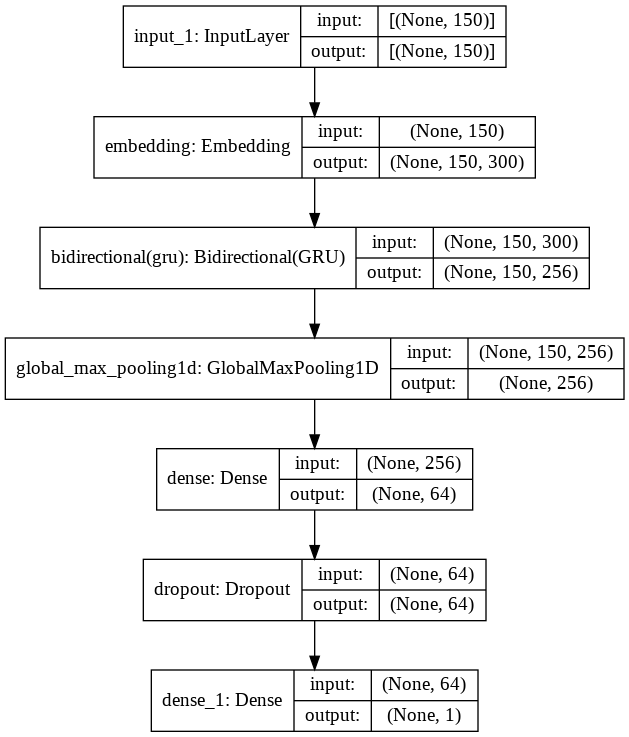

In [ ]:
plot_model(model_binary, show_shapes=True)

### Train model

In [ ]:
history_binary = model_binary.fit(X_train_1, y_train_1, batch_size=256, epochs=20, 
                                  callbacks=callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                                  validation_data=(X_val_1, y_val_1))

Epoch 1/20
650/650 [==============================] - 104s 144ms/step - loss: 0.2576 - precision: 0.8663 - accuracy: 0.8913 - auc: 0.9426 - val_loss: 0.1684 - val_precision: 0.8775 - val_accuracy: 0.9311 - val_auc: 0.9806
Epoch 2/20
650/650 [==============================] - 93s 142ms/step - loss: 0.1675 - precision: 0.9007 - accuracy: 0.9322 - auc: 0.9793 - val_loss: 0.1594 - val_precision: 0.8711 - val_accuracy: 0.9366 - val_auc: 0.9842
Epoch 3/20
650/650 [==============================] - 93s 143ms/step - loss: 0.1518 - precision: 0.9097 - accuracy: 0.9386 - auc: 0.9830 - val_loss: 0.1363 - val_precision: 0.8960 - val_accuracy: 0.9461 - val_auc: 0.9875
Epoch 4/20
650/650 [==============================] - 93s 143ms/step - loss: 0.1314 - precision: 0.9218 - accuracy: 0.9481 - auc: 0.9871 - val_loss: 0.1280 - val_precision: 0.8963 - val_accuracy: 0.9497 - val_auc: 0.9893
Epoch 5/20
650/650 [==============================] - 93s 142ms/step - loss: 0.1208 - precision: 0.9263 - accuracy:

### Evaluation

Plot learning curves

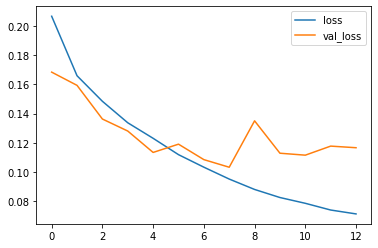

In [ ]:
pd_history_binary = pd.DataFrame(history_binary.history)
pd_history_binary.plot(y=['loss', 'val_loss'])

Make predictions on the test set

In [ ]:
y_scores_binary = model_binary.predict(X_test_1)

Assign binary value to each label to compute accuracy

In [ ]:
threshold = 0.5
y_pred_binary = [[1 if label >= threshold else 0 for label in score] for score in y_scores_binary]

Measure the performance of the model

In [ ]:
print('Accuracy (vector of labels must match):', round(accuracy_score(y_test_1, y_pred_binary), 5))
print('ROC AUC:', round(roc_auc_score(y_test_1, y_scores_binary, average='macro'), 5))
print('Precision:', round(precision_score(y_test_1, y_pred_binary, average='macro'), 5))
print('Recall:', round(recall_score(y_test_1, y_pred_binary, average='macro'), 5))
print('F1 score:', round(f1_score(y_test_1, y_pred_binary, average='macro'), 5))
print(confusion_matrix(y_test_1, y_pred_binary))
# plot_roc(y_test_1, y_scores_binary)

Accuracy (vector of labels must match): 0.87836
ROC AUC: 0.96483
Precision: 0.71809
Recall: 0.90522
F1 score: 0.76542
[[49932  7343]
 [  383  5859]]


## Save model and prediction

In [ ]:
# save model
model_binary.save(MODEL_DIR + 'gru_bin.h5', save_format='h5')
# save predictions
y_pred_binary = pd.DataFrame(y_pred_binary, columns=['is_toxic'])
y_pred_binary.to_csv(PRED_DIR + 'gru_bin.csv', index=False, sep='\t')